In [74]:
import importlib
import sys
import h5py
import scipy.io
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import pairwise_distances
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupShuffleSplit

sys.path.insert(0, "D:/PhD/tangent_space_analysis/")
                
import TSAfuncs as tsa
importlib.reload(tsa)

<module 'TSAfuncs' from 'D:\\PhD/tangent_space_analysis\\TSAfuncs.py'>

In [44]:
parent_dir = os.getcwd()

#parent_dir = 'parent dir here'
dfOG = pd.read_csv(parent_dir + "\\" + 'FC_project_dataframe.csv')

dfOG = dfOG[(dfOG['Num Subnets'] == 17) & (dfOG['Num Parcels'] == 200)]
tasklist = ['Rest', 'Motor']#, 'Memory']
FCs = list()

rest_df = pd.DataFrame()
dfOG.head(10)

for index,row in dfOG.iterrows():
    f = scipy.io.loadmat(row['Path'])
    subject_id = str(row['Subject'])
    state = 'rest'
    session = row['rest']
    FCs.append(tsa.FC(np.array(f['C']), subject = subject_id, state = state, session = session))
    

In [60]:
#generate tangent space projection
regvals = np.linspace(-4,2,10)
for reg in regvals:
    [x.tangent_space_projection(reg = 10**reg) for x in FCs];

logm result may be inaccurate, approximate err = 2.3431618146043767e-13
logm result may be inaccurate, approximate err = 2.756204044639627e-13
logm result may be inaccurate, approximate err = 2.481024692402407e-13
logm result may be inaccurate, approximate err = 2.320396084963536e-13
logm result may be inaccurate, approximate err = 2.8151025836827644e-13
logm result may be inaccurate, approximate err = 2.5356626969043283e-13
logm result may be inaccurate, approximate err = 2.679575697879141e-13
logm result may be inaccurate, approximate err = 2.6967859714440003e-13
logm result may be inaccurate, approximate err = 2.5105508349128483e-13
logm result may be inaccurate, approximate err = 2.3110603279108544e-13
logm result may be inaccurate, approximate err = 2.553336549938957e-13
logm result may be inaccurate, approximate err = 2.4633317778571336e-13
logm result may be inaccurate, approximate err = 2.5472607982396756e-13
logm result may be inaccurate, approximate err = 2.343841679941053e-1

In [61]:
regflow, df = tsa.get_regularization_flow(FCs, 10**regvals)

In [62]:

# #Perform PCA
pca = PCA(n_components=20)  # Reduce to 2 dimensions
score = pca.fit_transform(regflow)  # Transformed data
  
#Step 2: Extract the First Two Principal Components
Y = score[:, :20]



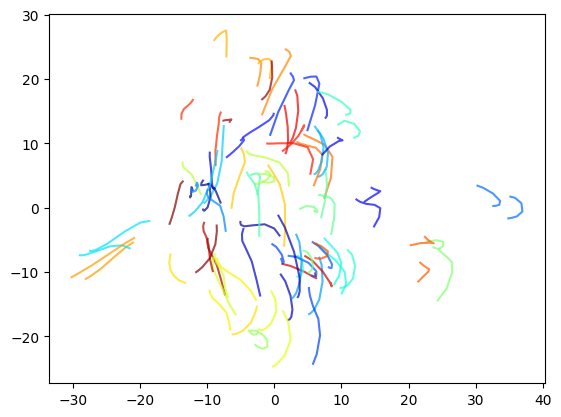

In [80]:
tsa.plot_regflow_pca(Y, 10, df, labels = df['subject'].values)

Classification Accuracy: 5.00%


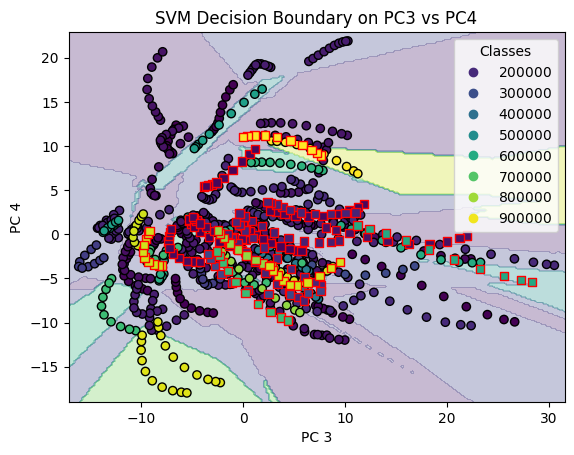

In [24]:
regflow = np.array(regflow)
#classifiy using SVM on PCA according to regularization trajectories
labels = np.array(subjects)
#labels = np.array(subjects)


# 1. Create a DataFrame to organize the information
df = pd.DataFrame({
    'subject': subjects,
    'task': states,
    'session': sessions,
    'index': np.arange(np.shape(regflow)[0])
})

# Create a composite key: for example, "subject_task_session"
df['group'] = df.apply(lambda row: f"{row['subject']}_{row['task']}_{row['session']}", axis=1)

#Sort the DataFrame so that rows from the same group are together
df_sorted = df.sort_values(by=['group'])
sorted_idx = df_sorted['index'].values

# Reorder regflow and labels accordingly
regflow_sorted = regflow[sorted_idx]
labels_sorted = labels[sorted_idx]


# Also extract the group labels in the sorted order
groups_sorted = df_sorted['group'].values

# 3. Use GroupShuffleSplit to split the data by session (group)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2)#, random_state=39)
train_idx, val_idx = next(gss.split(regflow_sorted, groups=groups_sorted))

X_train = regflow_sorted[train_idx]
X_val = regflow_sorted[val_idx]
y_train = labels_sorted[train_idx]
y_val = labels_sorted[val_idx]

#apply pca
pca = PCA(n_components=min(X_train.shape[1], X_train.shape[0]))  # Keep all PCs
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

pc_x = 2
pc_y = pc_x + 1
X_train_selected = X_train_pca[:, [pc_x, pc_y]]
X_val_selected = X_val_pca[:, [pc_x, pc_y]]


svm = SVC(kernel='linear', C=1, gamma='scale')
svm.fit(X_train_selected, y_train)

#predict the lbaels
y_pred = svm.predict(X_val_selected)

#Compute classification accuracy
accuracy = accuracy_score(y_val, y_pred)

print(f"Classification Accuracy: {accuracy * 100:.2f}%")



x_min, x_max = X_train_selected[:, 0].min() - 1, X_train_selected[:, 0].max() + 1
y_min, y_max = X_train_selected[:, 1].min() - 1, X_train_selected[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

#Predict class for each point in the mesh grid
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
scatter = plt.scatter(X_train_selected[:, 0], X_train_selected[:, 1], c=y_train, edgecolors='k', cmap='viridis')

#Plot validation points
plt.scatter(X_val_selected[:, 0], X_val_selected[:, 1], c=y_val, edgecolors='r', marker='s', cmap='viridis')



#Formatting
plt.xlabel(f"PC {pc_x + 1}")  # Adjust for human-readable PC index
plt.ylabel(f"PC {pc_y + 1}")
plt.title(f"SVM Decision Boundary on PC{pc_x+1} vs PC{pc_y+1}")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


In [2163]:
np.shape(FCs)

(141, 333, 333)

In [2429]:
#subnetwork analysis
subnets = pd.read_csv('/home/dcuric/Documents/tangentSpace/MNSC/subnetworks.csv')
subnetid = subnets['subnet'].unique()

refidx = 1
accuracy_task = np.zeros(len(subnetid))
accuracy_subj = np.zeros(len(subnetid))
for s in subnetid:
  
    idx = list(subnets[subnets['subnet'] == s]['ROI'].values - 1)
    if len(idx) < 10:
        print(len(idx))
        print('here')
        continue
    print(idx)
    subFC = [f[idx,:][:,idx] for f in FCs]

    ref_FC, ref_df, test_FC, test_df = get_ref_and_test_FC(subFC, rest_df, refidx)#, subject)    
    print(np.shape(test_FC))
    print(np.shape(ref_FC))
    
    [regflow, subjects, sessions, tasks] = get_regularization_flow(test_FC, test_df, ref_FC = ref_FC, start = -2, stop = 4, step = 10)#, start = -2, stop = 4, steps = 5, num_components = 3)
    print(np.shape(regflow))
    categories = {'Rest':0, 'Motor':1, 'Memory':2}
    tasklabels = [categories[x] for x in tasks]
    
    # # #Perform PCA
    # pca = PCA(n_components=20)  # Reduce to 2 dimensions
    # score = pca.fit_transform(regflow)  # Transformed data
      
    # #Step 2: Extract the First Two Principal Components
    # Y = score[:, :20]
    #classifiy using SVM on PCA according to regularization trajectories
    labels_task = np.array(tasklabels)
    labels_subject = np.array(tasklabels)
    
    
    # 1. Create a DataFrame to organize the information
    df = pd.DataFrame({
        'subject': subjects,
        'task': tasklabels,
        'session': sessions,
        'index': np.arange(np.shape(regflow)[0])
    })
    
    # Create a composite key: for example, "subject_task_session"
    df['group'] = df.apply(lambda row: f"{row['subject']}_{row['task']}_{row['session']}", axis=1)
    
    #Sort the DataFrame so that rows from the same group are together
    df_sorted = df.sort_values(by=['group'])
    sorted_idx = df_sorted['index'].values
    
    # Reorder regflow and labels accordingly
    regflow_sorted = regflow[sorted_idx]
    labels_task_sorted = labels_task[sorted_idx]
    labels_subj_sorted = labels_subject[sorted_idx]
    
    
    # Also extract the group labels in the sorted order
    groups_sorted = df_sorted['group'].values
    
    # 3. Use GroupShuffleSplit to split the data by session (group)
    gss = GroupShuffleSplit(n_splits=2, test_size=0.2)#, random_state=39)
    train_idx, val_idx = next(gss.split(regflow_sorted, groups=groups_sorted))
    
    X_train = regflow_sorted[train_idx]
    X_val = regflow_sorted[val_idx]
    y_task_train = labels_task_sorted[train_idx]
    y_task_val = labels_task_sorted[val_idx]
    y_subj_train = labels_subj_sorted[train_idx]
    y_subj_val = labels_subj_sorted[val_idx]
    
     
    #apply pca
    pca = PCA(n_components=min(X_train.shape[1], X_train.shape[0]))  # Keep all PCs
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)

    #######classify the task
    pc_x = 7
    pc_y = pc_x + 1
    X_train_selected = X_train_pca[:, [pc_x, pc_y]]
    X_val_selected = X_val_pca[:, [pc_x, pc_y]]
    
    svm = SVC(kernel='linear', C=1, gamma='scale')
    svm.fit(X_train_selected, y_task_train)
    
    #predict the lbaels
    y_pred = svm.predict(X_val_selected)
    
    #Compute classification accuracy
    accuracy_task[s-1] = accuracy_score(y_task_val, y_pred)

    #######classify the subject
    pc_x = 0
    pc_y = pc_x + 1
    X_train_selected = X_train_pca[:, [pc_x, pc_y]]
    X_val_selected = X_val_pca[:, [pc_x, pc_y]]
    
    svm = SVC(kernel='linear', C=1, gamma='scale')
    svm.fit(X_train_selected, y_subj_train)
    
    #predict the lbaels
    y_pred = svm.predict(X_val_selected)
    
    #Compute classification accuracy
    accuracy_subj[s-1] = accuracy_score(y_subj_val, y_pred)
    
    
    

[10, 17, 18, 72, 114, 117, 118, 119, 120, 121, 122, 123, 124, 127, 128, 132, 133, 134, 141, 143, 158, 171, 177, 178, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 290, 291, 295, 296, 299, 300, 301, 302, 303, 304, 305, 311, 313]
(85, 47, 47)
(8, 47, 47)
(850, 1081)
[0, 3, 5, 24, 25, 43, 93, 113, 115, 116, 125, 126, 144, 145, 149, 150, 151, 153, 155, 156, 161, 164, 183, 185, 199, 219, 224, 256, 258, 277, 278, 289, 314, 315, 320, 321, 322, 323, 324, 325, 330]
(85, 41, 41)
(8, 41, 41)
(850, 820)
[4, 7, 14, 15, 16, 19, 89, 96, 97, 98, 130, 131, 135, 136, 137, 138, 139, 140, 165, 168, 174, 175, 176, 250, 254, 255, 257, 262, 263, 264, 266, 292, 297, 298, 306, 307, 308, 309, 310]
(85, 39, 39)
(8, 39, 39)
(850, 741)
[6, 8, 23, 77, 95, 107, 108, 147, 148, 166, 167, 169, 181, 239, 259, 260, 271, 272, 275, 276, 318, 319, 326, 327]
(85, 24, 24)
(8, 24, 24)
(850, 276)
[40, 41, 42, 48, 50, 51, 54, 73, 86, 87, 90, 91, 94, 99, 105, 106, 109, 112, 154, 188, 198, 202, 207, 210, 235, 249, 251, 252, 26

Text(0, 0.5, 'Task Accuracy')

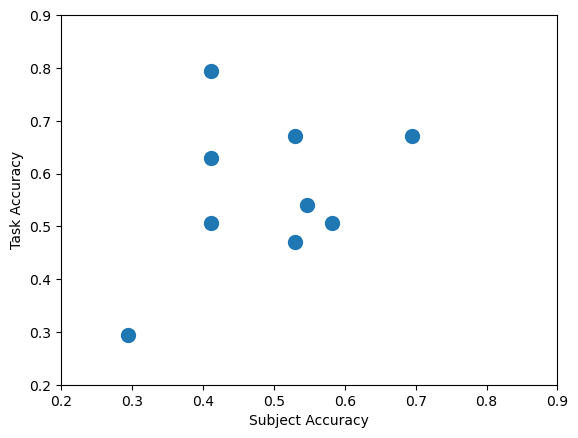

In [2461]:
plt.plot(accuracy_subj, accuracy_task, '.', markersize = 20)
ax = plt.gca()
ax.set_xlim([0.2, 0.9])
ax.set_ylim([0.2, 0.9])
ax.set_xlabel('Subject Accuracy')
ax.set_ylabel('Task Accuracy')

In [2413]:
subnets.head(50)

,ROI,subnet
0,11,1
1,18,1
2,19,1
3,73,1
4,115,1
5,118,1
6,119,1
7,120,1
8,121,1
9,122,1
